In [ ]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.utils import save_image

In [ ]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [ ]:
latent_dim = 100 # suggested default. dimensionality of the latent space

In [ ]:
cuda = True if torch.cuda.is_available() else False # GPU Setting
cuda

False

In [ ]:
n_classes = 10

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
adversarial_loss = torch.nn.MSELoss()

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator


Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
discriminator


Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

print(count_parameters(generator))
print(count_parameters(discriminator))

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
| label_emb.weight |    100     |
|  model.0.weight  |   14080    |
|   model.0.bias   |    128     |
|  model.2.weight  |   32768    |
|   model.2.bias   |    256     |
|  model.3.weight  |    256     |
|   model.3.bias   |    256     |
|  model.5.weight  |   131072   |
|   model.5.bias   |    512     |
|  model.6.weight  |    512     |
|   model.6.bias   |    512     |
|  model.8.weight  |   524288   |
|   model.8.bias   |    1024    |
|  model.9.weight  |    1024    |
|   model.9.bias   |    1024    |
| model.11.weight  |   802816   |
|  model.11.bias   |    784     |
+------------------+------------+
Total Trainable Params: 1511412
1511412
+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| label_embedding.weight |    100     |
|     model.0.weight     |   406528   |
|      model.0.bias      |    512     |
|     

In [ ]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [ ]:
import pandas as pd
from torch.utils.data import Dataset
from torchvision.datasets import MNIST

In [ ]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # to scale images from [0, 1] to [-1, -1]
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 134327087.71it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32730530.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37374307.71it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3377154.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
temp_img, _ =  dataset.__getitem__(0) # We don't need label, so _

In [ ]:
temp_img.size()

torch.Size([1, 28, 28])

In [ ]:
28 // 4

7

In [ ]:
temp_img.max(), temp_img.min() # before Normalize([0.5],[0.5]) : 0 ~ 1, after : -1 ~ 1

(tensor(1.), tensor(-1.))

In [ ]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [ ]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [ ]:
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [ ]:
sample_interval = 200

In [ ]:
# Visualize result
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



In [ ]:
labels

tensor([3, 1, 8, 1, 8, 7, 8, 4, 9, 6, 3, 1, 0, 0, 1, 3, 0, 7, 3, 5, 8, 9, 4, 6,
        6, 6, 2, 7, 2, 8, 2, 3, 0, 7, 7, 6, 1, 6, 2, 9, 9, 5, 1, 2, 6, 8, 0, 8,
        9, 1, 6, 7, 1, 2, 8, 0, 7, 7, 7, 4, 8, 0, 9, 8, 9, 4, 1, 6, 1, 2, 3, 5,
        0, 9, 9, 2, 1, 7, 9, 7, 7, 4, 7, 7, 5, 6, 2, 7, 8, 2, 4, 4, 8, 0, 1, 5])

In [ ]:

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

In [ ]:
real_imgs.shape

torch.Size([96, 1, 28, 28])

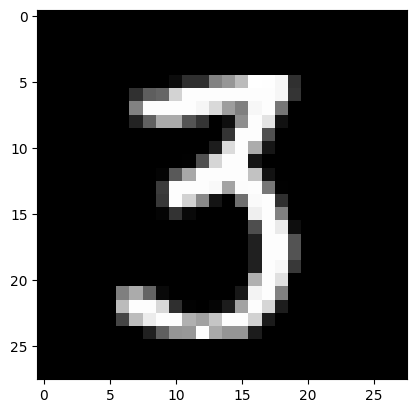

In [ ]:
plt.imshow(real_imgs[0].permute(1,2,0), cmap='gray')

  0%|          | 0/235 [00:00<?, ?it/s]

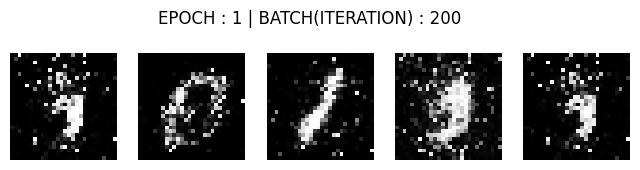

[Epoch: 1/25] [Batch: 235/235] [D loss: 0.096868] [G loss: 1.005494]


  0%|          | 0/235 [00:00<?, ?it/s]

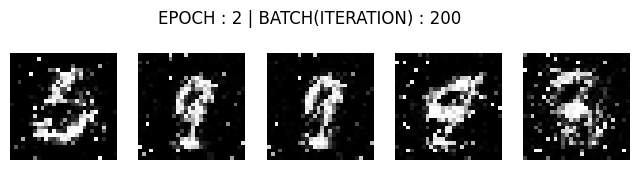

[Epoch: 2/25] [Batch: 235/235] [D loss: 0.079568] [G loss: 0.604833]


  0%|          | 0/235 [00:00<?, ?it/s]

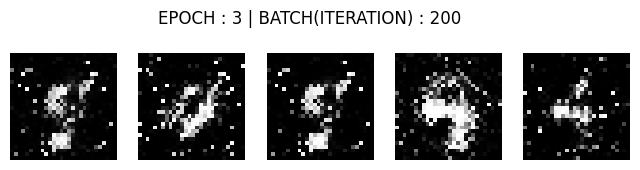

[Epoch: 3/25] [Batch: 235/235] [D loss: 0.078925] [G loss: 0.585669]


  0%|          | 0/235 [00:00<?, ?it/s]

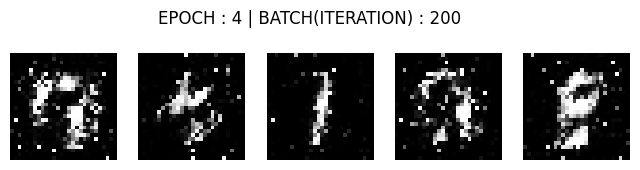

[Epoch: 4/25] [Batch: 235/235] [D loss: 0.063045] [G loss: 0.661063]


  0%|          | 0/235 [00:00<?, ?it/s]

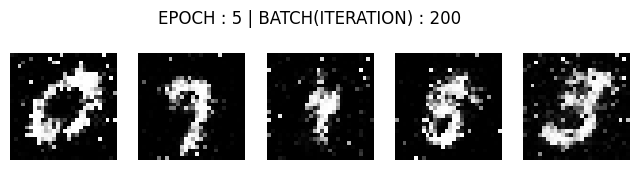

[Epoch: 5/25] [Batch: 235/235] [D loss: 0.116807] [G loss: 0.412509]


  0%|          | 0/235 [00:00<?, ?it/s]

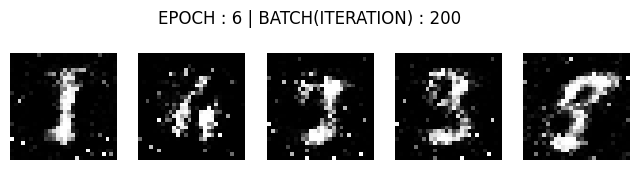

[Epoch: 6/25] [Batch: 235/235] [D loss: 0.081693] [G loss: 0.837920]


  0%|          | 0/235 [00:00<?, ?it/s]

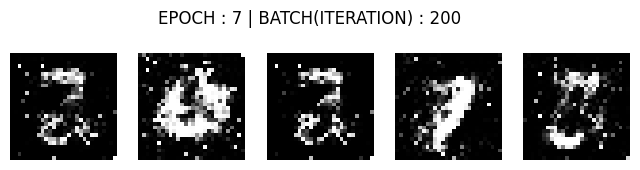

[Epoch: 7/25] [Batch: 235/235] [D loss: 0.071835] [G loss: 0.742798]


  0%|          | 0/235 [00:00<?, ?it/s]

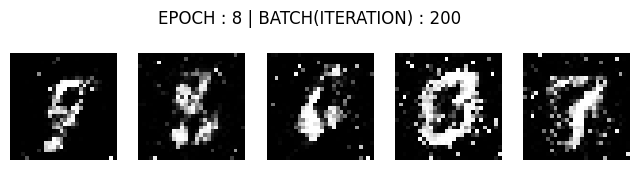

[Epoch: 8/25] [Batch: 235/235] [D loss: 0.068047] [G loss: 0.747767]


  0%|          | 0/235 [00:00<?, ?it/s]

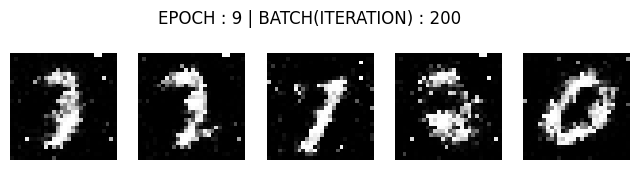

[Epoch: 9/25] [Batch: 235/235] [D loss: 0.096636] [G loss: 0.872262]


  0%|          | 0/235 [00:00<?, ?it/s]

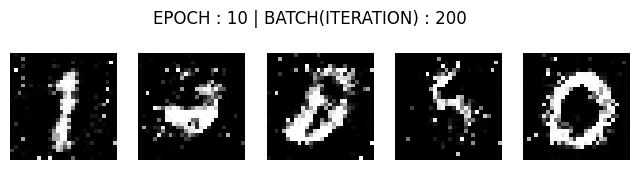

[Epoch: 10/25] [Batch: 235/235] [D loss: 0.080480] [G loss: 0.686775]


  0%|          | 0/235 [00:00<?, ?it/s]

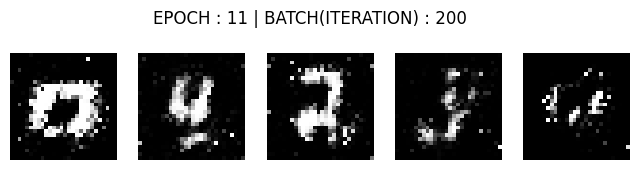

[Epoch: 11/25] [Batch: 235/235] [D loss: 0.236864] [G loss: 0.162206]


  0%|          | 0/235 [00:00<?, ?it/s]

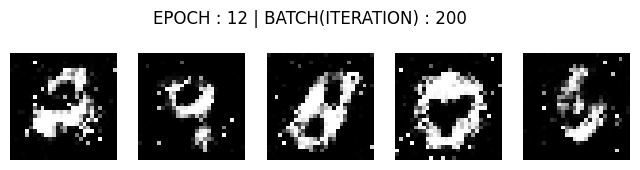

[Epoch: 12/25] [Batch: 235/235] [D loss: 0.113901] [G loss: 0.665345]


  0%|          | 0/235 [00:00<?, ?it/s]

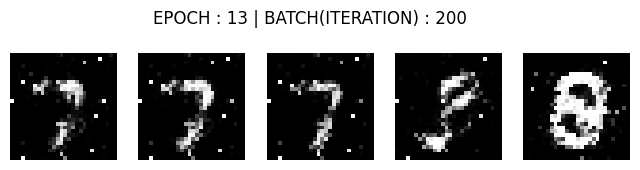

[Epoch: 13/25] [Batch: 235/235] [D loss: 0.145392] [G loss: 0.362065]


  0%|          | 0/235 [00:00<?, ?it/s]

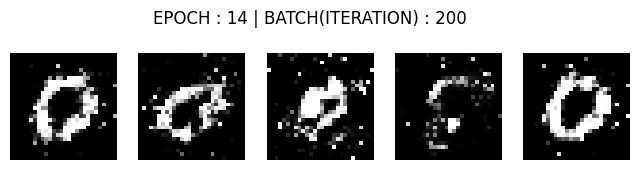

[Epoch: 14/25] [Batch: 235/235] [D loss: 0.144144] [G loss: 0.361316]


  0%|          | 0/235 [00:00<?, ?it/s]

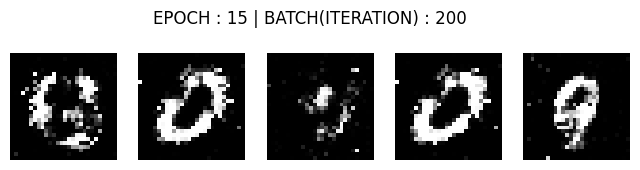

[Epoch: 15/25] [Batch: 235/235] [D loss: 0.092680] [G loss: 0.690751]


  0%|          | 0/235 [00:00<?, ?it/s]

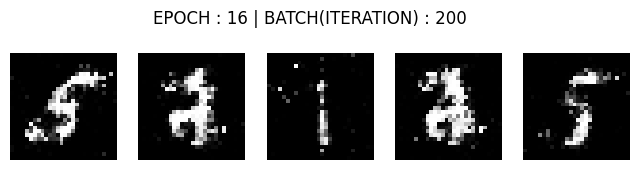

[Epoch: 16/25] [Batch: 235/235] [D loss: 0.114809] [G loss: 0.806287]


  0%|          | 0/235 [00:00<?, ?it/s]

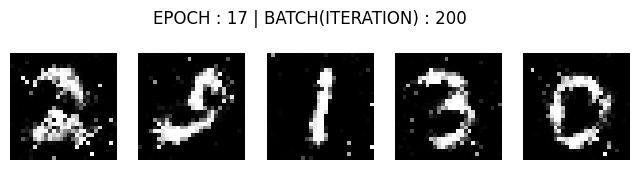

[Epoch: 17/25] [Batch: 235/235] [D loss: 0.119497] [G loss: 0.552388]


  0%|          | 0/235 [00:00<?, ?it/s]

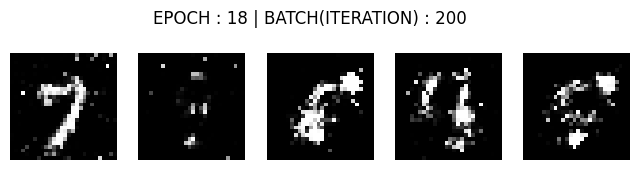

[Epoch: 18/25] [Batch: 235/235] [D loss: 0.106508] [G loss: 0.668337]


  0%|          | 0/235 [00:00<?, ?it/s]

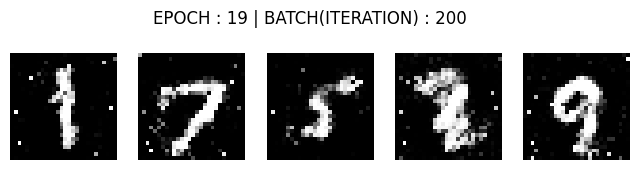

[Epoch: 19/25] [Batch: 235/235] [D loss: 0.117565] [G loss: 0.578374]


  0%|          | 0/235 [00:00<?, ?it/s]

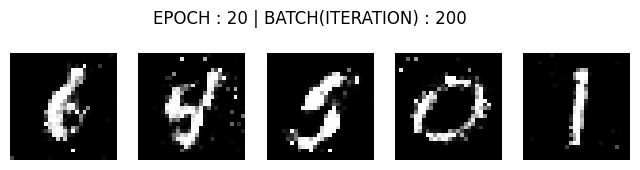

[Epoch: 20/25] [Batch: 235/235] [D loss: 0.157144] [G loss: 0.320403]


  0%|          | 0/235 [00:00<?, ?it/s]

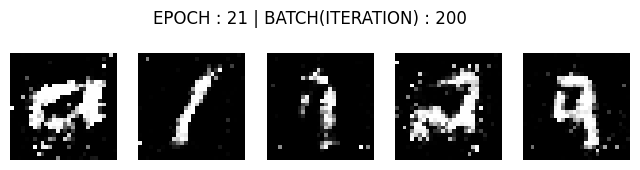

[Epoch: 21/25] [Batch: 235/235] [D loss: 0.089472] [G loss: 0.618296]


  0%|          | 0/235 [00:00<?, ?it/s]

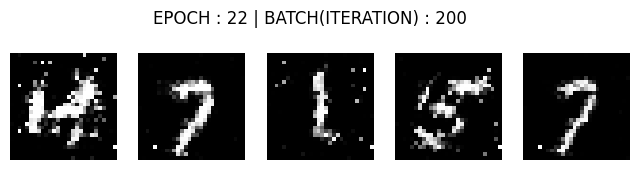

[Epoch: 22/25] [Batch: 235/235] [D loss: 0.114711] [G loss: 0.648140]


  0%|          | 0/235 [00:00<?, ?it/s]

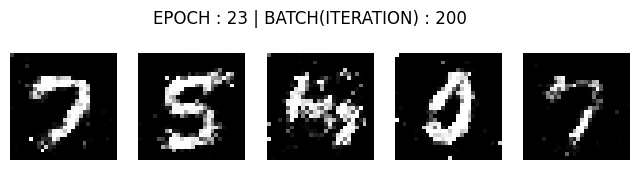

[Epoch: 23/25] [Batch: 235/235] [D loss: 0.127655] [G loss: 0.672184]


  0%|          | 0/235 [00:00<?, ?it/s]

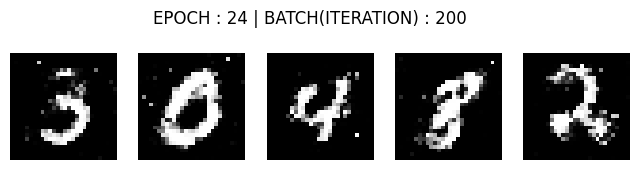

[Epoch: 24/25] [Batch: 235/235] [D loss: 0.147281] [G loss: 0.579968]


  0%|          | 0/235 [00:00<?, ?it/s]

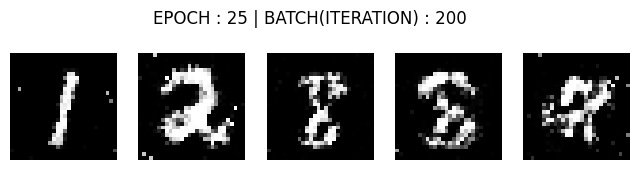

[Epoch: 25/25] [Batch: 235/235] [D loss: 0.129925] [G loss: 0.756231]


In [ ]:
n_epochs = 25 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor)) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
        labels = Variable(labels.type(LongTensor))
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (imgs.size(0), latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, imgs.size(0))))
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)


        g_loss.backward()
        optimizer_G.step()

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)
        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()



# ------------
# Real Time Visualization (While Training)
# ------------

        sample_z_in_train = FloatTensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        gen_labels_in_train = Variable(LongTensor(np.random.randint(0, n_classes, imgs.shape[0])))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train, gen_labels_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )


In [ ]:
# latent vector
sample_z = Tensor(np.random.normal(0, 1, (64,100)))
gen_labels = Variable(LongTensor(np.random.randint(0, 1, 64)))
sample_z.shape


torch.Size([64, 100])

In [ ]:
gen_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# generated images
sample_gen_imgs = generator(sample_z, gen_labels).detach().cpu()
sample_gen_imgs.shape


torch.Size([64, 1, 28, 28])

In [ ]:
sample_z

tensor([[ 0.6992, -0.8500, -0.0608,  ...,  0.3409, -0.1906, -0.2261],
        [-2.1442,  0.7354,  1.7101,  ..., -0.2065, -0.5593,  0.2933],
        [-1.0458,  0.5229, -0.3818,  ...,  1.0772, -0.3782,  0.0617],
        ...,
        [-0.1482, -3.5027,  0.9046,  ..., -0.1874,  0.9147,  0.6183],
        [ 1.3290,  1.3970, -0.0315,  ...,  1.0073,  0.1389, -0.3026],
        [-1.5164, -0.6712,  0.4882,  ..., -1.2048, -0.0739,  0.3403]])

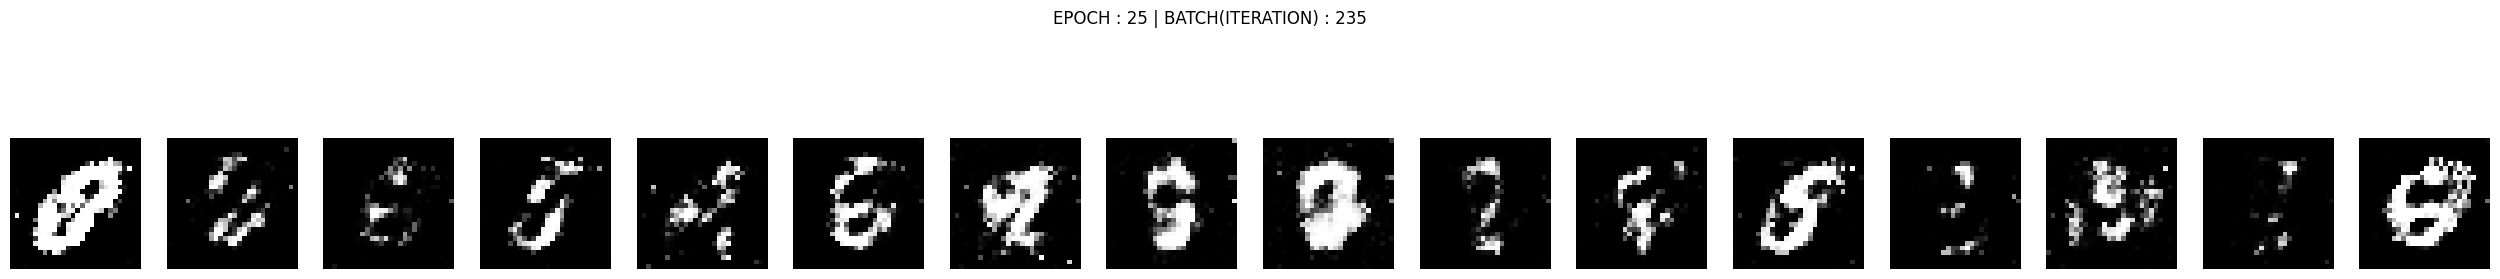

In [ ]:
nrow=1
ncols=16
fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(32,4))
plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
for ncol in range(ncols):
    axes[ncol].imshow(sample_gen_imgs.permute(0,2,3,1)[ncol], cmap='gray')
    axes[ncol].axis('off')
plt.show()

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

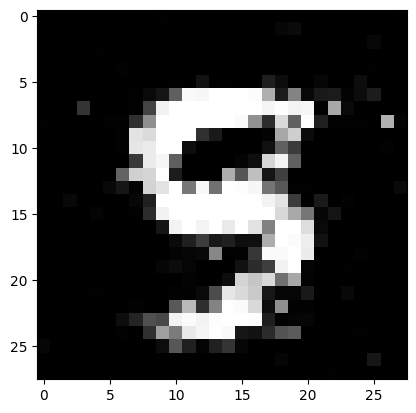

In [ ]:
show(sample_gen_imgs[3, :, :, :].detach())

In [ ]:
sample_gen_imgs[0, :, :, :].detach().shape

torch.Size([1, 28, 28])

In [ ]:
sample_gen_imgs

tensor([[[[-0.9963, -0.9916, -0.9959,  ..., -0.9988, -0.9971, -0.9953],
          [-0.9932, -0.9992, -0.9996,  ..., -0.9988, -0.9979, -0.9956],
          [-0.9932, -0.9993, -0.9976,  ..., -0.9900, -0.9956, -0.9984],
          ...,
          [-0.9870, -0.9951, -0.9867,  ..., -0.9981, -0.9993, -0.9959],
          [-0.6446, -0.9922, -0.9990,  ..., -0.9995, -0.9950, -0.9997],
          [-0.9976, -0.9942, -0.9988,  ..., -0.9819, -0.9991, -0.9965]]],


        [[[-0.9879, -0.9891, -0.9826,  ..., -0.9863, -0.9843, -0.9885],
          [-0.9854, -0.9961, -0.9976,  ..., -0.9948, -0.9965, -0.9837],
          [-0.9915, -0.9962, -0.9935,  ..., -0.8323, -0.9734, -0.9949],
          ...,
          [-0.8848, -0.9803, -0.9684,  ..., -0.9965, -0.9931, -0.9911],
          [ 0.8399, -0.9891, -0.9923,  ..., -0.9941, -0.9897, -0.9973],
          [-0.9922, -0.9712, -0.9963,  ..., -0.9908, -0.8860, -0.9836]]],


        [[[-0.9909, -0.9905, -0.9846,  ..., -0.9882, -0.9869, -0.9913],
          [-0.9872, -0.996